In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import string
import re
import joblib
import pickle


from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sqlalchemy import create_engine
from confident import *
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [66]:
df = pd.read_csv('datasets/billboard.zip')
df.head()

,date,year,title,simple_title,artist,main_artist,peak_pos,last_pos,weeks,rank,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
0,6/21/18,NaN,4th Dimension,NaN,Kanye West and Kid Cudi,NaN,42,0,1,42,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Error: Could not find lyrics.
1,6/21/18,NaN,All Girls Are The Same,NaN,Juice WRLD,NaN,41,49,5,41,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,NaN,All Mine,NaN,Kanye West,NaN,11,11,2,31,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
3,6/21/18,NaN,Alone,NaN,Halsey Featuring Big Sean & Stefflon Don,NaN,70,73,9,74,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Error: Could not find lyrics.
4,6/21/18,NaN,Babe,NaN,Sugarland Featuring Taylor Swift,NaN,72,0,2,95,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,Error: Could not find lyrics.


In [67]:
df.shape

(7573, 31)

In [68]:
# Removing all rows that did not return lyrics
df = df[df['lyrics'].str.contains("Error: Could not find lyrics.") == False]

In [69]:
df.shape

(7228, 31)

In [70]:
df.head()

,date,year,title,simple_title,artist,main_artist,peak_pos,last_pos,weeks,rank,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,NaN,All Girls Are The Same,NaN,Juice WRLD,NaN,41,49,5,41,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,NaN,All Mine,NaN,Kanye West,NaN,11,11,2,31,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,NaN,Back To You,NaN,Selena Gomez,NaN,22,31,5,22,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,NaN,Be Careful,NaN,Cardi B,NaN,11,25,11,23,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,NaN,Beautiful Crazy,NaN,Luke Combs,NaN,58,77,4,93,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


In [71]:
# Removing unnecessary columns from the dataframe
cols = ['simple_title', 'main_artist', 'year', 'peak_pos', 'last_pos', 'weeks', 'rank', 'change', 'video_link', 'broad_genre']
df = df.drop(cols, axis=1)

In [72]:
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,[u'rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"[u'pop rap', u'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"[u'dance pop', u'pop', u'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"[u'pop', u'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"[u'contemporary country', u'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


In [73]:
# This function removes the unnecessary "u" from each list of genres.
def genre_preprocess(text : str) -> str:
    text = re.sub("u'", "'", text)
    return text

In [74]:
# Run the function defined above on the "genre" column
df['genre'] = df.genre.apply(genre_preprocess)
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,['rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"['pop rap', 'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"['dance pop', 'pop', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"['pop', 'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"['contemporary country', 'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


In [75]:
df.shape

(7228, 21)

In [76]:
# This function cleans the text in the "lyrics" column
def clean_lyrics(text):
    text = text.lower()
    text = text.encode('ascii', 'ignore').decode()
    stop_words = stopwords.words('english')
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\w*\d+\w*', '', text)
    text = re.sub('\s{2,}', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub(' s ', ' ', text)
    text = re.sub(' m ', ' ', text)
    return text

In [77]:
# Apply the function defined above onto the "lyrics" colummn, also creating a new column called "clean_lyrics" as to not overwrite the original "lyrics" column
df['clean_lyrics'] = df.lyrics.apply(clean_lyrics)

In [78]:
# Removes unnecessary white space and ensures each word is delimited by a single space.
text = " ".join(i for i in df.clean_lyrics)

In [79]:
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics,clean_lyrics
1,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,['rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are...",they re rotting brain love these hoes same i a...
2,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"['pop rap', 'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus...",yeah supermodel thick damn ass bustin bottom i...
5,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"['dance pop', 'pop', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...,took like shot thought could chase cold evenin...
7,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"['pop', 'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ...",yeah be careful careful careful me yeah look i...
8,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"['contemporary country', 'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...,day starts coffee and ends wine takes forever ...


In [80]:
df.shape

(7228, 22)

In [81]:
# Dropping all duplicates from the dataset. Some of the spotify IDs were duplicated
df = df.drop_duplicates(subset='spotify_id')

In [82]:
# Dropping all rows with a NULL value for the spotify_id column
df = df.dropna(subset=['spotify_id'])

In [83]:
# Reseting the index count to avoid multiple rows having the same index and to avoid fractured index counts.
df = df.reset_index(drop=True)
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics,clean_lyrics
0,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,['rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are...",they re rotting brain love these hoes same i a...
1,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"['pop rap', 'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus...",yeah supermodel thick damn ass bustin bottom i...
2,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"['dance pop', 'pop', 'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...,took like shot thought could chase cold evenin...
3,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"['pop', 'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ...",yeah be careful careful careful me yeah look i...
4,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"['contemporary country', 'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...,day starts coffee and ends wine takes forever ...


In [84]:
df.shape

(6776, 22)

Text Visualization

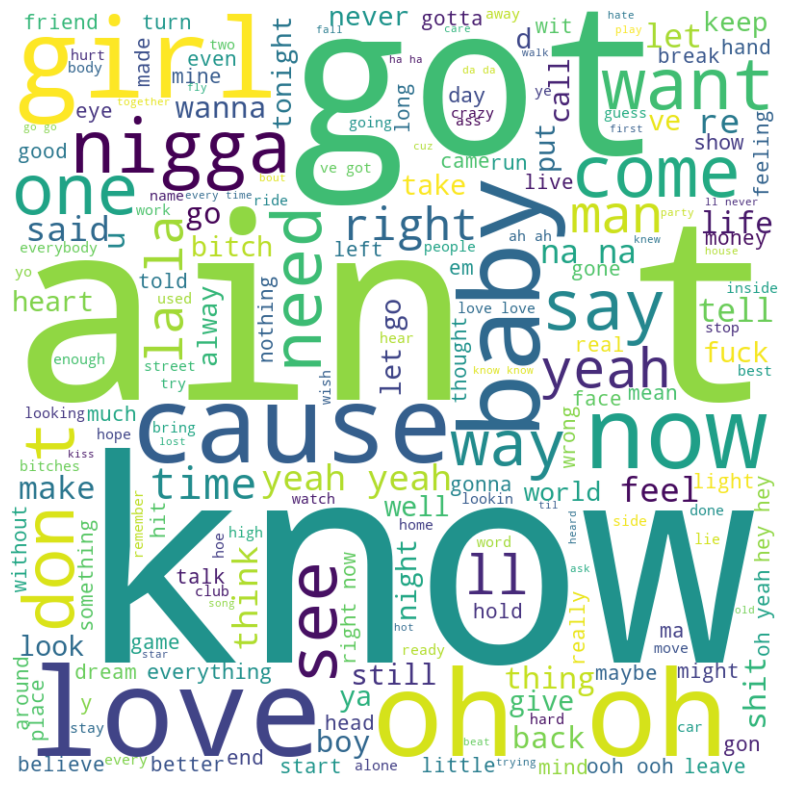

In [85]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [86]:
def get_playlist_details(df, spotify_ids):
    """This function takes in the user's playlist and returns the spotify IDs and the playlist lyrics.
    
        Args -
            df : A 2D pandas dataframe that contains the cleaned dataset.
            spotify_id : A list of strings that contains the spotify IDs of the users playlist
             
        Returns -
            user_playlist_song_ids : A list of strings that contains the song IDs of the user's playlist.
            user_playlist_lyrics : A single string that contains all of the lyrics of the user's playlist.
            """
    

    row_num = df[df['spotify_id'].isin(spotify_ids)]
    print("Playlist User Enterd:")
    print(row_num[['title', 'artist', 'spotify_id']])

    # Get the Spotify IDs for the songs in the user's playlist
    user_playlist_song_ids = row_num['spotify_id']

    # Combine the lyrics from each of the songs in the user's playlist into one string
    user_playlist_lyrics = ' '.join(row_num['clean_lyrics'].tolist())

    # Return the Spotify song IDs and the string containing the lyrics of the entire playlist
    return user_playlist_song_ids, user_playlist_lyrics

Here I am generating a random playlist in order to test the function. 
    - I generate a random playlist.
    - Pass in the dataframe containing all songs and the spotify IDs from the playlist I just generated.
    - Return the song IDs and the lyrics from the playlist

In [111]:
sp_ids = df['spotify_id']
user_playlist_song_ids, user_playlist_lyrics = get_playlist_details(df=df, spotify_ids=sp_ids.sample(n=7))

Playlist User Enterd:
                         title           artist              spotify_id
1765       Slave To The Rhythm  michael jackson  4h5KB1btt2aZBq9EJHmWF4
2899                    Jolene   vicci martinez  7dF3kimGzXQVk1ZKx9k4sm
3986  See You In My Nightmares       kanye west  2vpVa09ocfQ3EqQJu2UQYw
4338           Citizen/Soldier     3 doors down  7fKsaiVDwKe6VVsiGk48YG
4431              When I See U         fantasia  4iuNZTcvT9diFySSzVsnVS
4646                  Maneater    nelly furtado  2YXShhHOx334ID9M4jXnPd
5742                  Ignition         r. kelly  0nmxH6IsSQVT1YEsCB9UMi


Here I am creating a Tf-idf vectorizer object, and fitting the clean lyrics column onto it.

In [88]:
def generate_recommendations(user_playlist_song_ids, user_playlist_lyrics):

    # Create a new column with the combined clean lyrics for each song
    clean_lyrics = df['clean_lyrics']

    # Create a Tf-idf vectorizer object
    vectorizer = TfidfVectorizer()

    # Fit the vectorizer to the lyrics, creating a tf-idf matrix where the words are the features
    tfidf_matrix = vectorizer.fit_transform(clean_lyrics)

    # Transform the user playlist into a Tf-idf vector
    user_tfidf = vectorizer.transform([user_playlist_lyrics])

    # Calculate the cosine similarities between the user playlist vector and all the songs
    cosine_similarities = cosine_similarity(user_tfidf, tfidf_matrix).flatten()

    # Sort the songs by similarity score in descending order
    song_indices = cosine_similarities.argsort()[::-1]

    # Get the top N number of song recommendations without duplicating the songs in the user's playlist
    recommended_songs = []
    for i in song_indices:
        if len(recommended_songs) == 10:
            break
        elif df.loc[i, 'spotify_id'] in user_playlist_song_ids:
            continue
        else:
            recommended_songs.append(df.loc[i, 'spotify_id'])

    # Return the recommended songs, what is returned are the spotify IDs of the songs
    return recommended_songs

In [89]:
# Test the function
recommendations = generate_recommendations(user_playlist_song_ids=user_playlist_song_ids, user_playlist_lyrics=user_playlist_lyrics)

# Obtaining the details (i.e the song title and artist) from the spotify IDs returned by the generate_recommendations function.
song_details = df[df['spotify_id'].isin(recommendations)].drop_duplicates(subset='spotify_id')

Evaluating the TF-IDF function

In [90]:
NUM_USERS = 100

# Create a list of user IDs and item IDs
user_ids = ['user{}'.format(i) for i in range (1, NUM_USERS + 1)]

# Grab all spotify IDs from the dataset
spotify_ids = df['spotify_id'].unique()

# Create a user-item matrix with random values for each user 
data = np.random.randint(0, 101, size=(100, 6776))
user_item_matrix = pd.DataFrame(data=data, index=user_ids, columns=spotify_ids)

In [91]:
# Find the maximum value for each user
max_vals = np.max(user_item_matrix, axis=1)

# Calculate the threshold value for the top 10% of the highest numbers in each row
thresholds = max_vals * 0.9

# Identify the columns that have values in the top 10% of the highest numbers in each row for each user
top_cols = user_item_matrix.values >= thresholds[:, np.newaxis]

# Convert the result to a DataFrame with the same columns as the input
top_cols_df = pd.DataFrame(top_cols, columns=user_item_matrix.columns)

# Rename the rows to match the user IDs
top_cols_df.index = user_item_matrix.index

/var/folders/b8/tkxd7yxj1672bq9d4m_3xmhh0000gn/T/ipykernel_13747/4220784890.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  top_cols = user_item_matrix.values >= thresholds[:, np.newaxis]


In [92]:
# Generate a random playlist for each user with 10 songs
user_playlists = {}
for user in user_ids:
    user_value = [ord(char) for char in user]
    user_value = int(sum(user_value) / len(user_value)) + random.randint(1, 100)
    np.random.seed(user_value) # use the user ID as the seed
    user_playlists[user] = np.random.choice(spotify_ids, size=10, replace=False)

user_recommendations = {}
for user, playlist in user_playlists.items():
    user_playlist_song_ids, user_playlist_lyrics = get_playlist_details(df=df, spotify_ids=playlist)
    user_recommendations[user] = generate_recommendations(user_playlist_song_ids=user_playlist_song_ids, user_playlist_lyrics=user_playlist_lyrics)

    # Obtaining the details (i.e the song title and artist) from the spotify IDs returned by the generate_recommendations function.
    song_details = df[df['spotify_id'].isin(user_recommendations[user])].drop_duplicates(subset='spotify_id')

Playlist User Enterd:
                        title                artist              spotify_id
861                    My PYT                  wale  4jK1VQQGDnNOLfyVXCxGsR
1302               Wet Dreamz               j. cole  6Ius4TC0L3cN74HT7ENE6e
2527        Where I Come From     montgomery gentry  5PxpphUBj6Dfqrii0irlMf
3004                   Higher             taio cruz  2vvNLCxH4ZYBiM37fi7ANi
3202        All About Tonight         blake shelton  5cQIrML7iJEUsOCNsHqWlB
3223              Ridin' Solo          jason derulo  7ksYJ95P5vP87A0GH34CIk
3861  Candle (Sick And Tired)  the white tie affair  7L2njnxdaRRvDMNLuP1ZcD
6539          Taking You Home            don henley  114ZIcx0S3gJkZmT3wmGte
6562                 Whatever                 ideal  3tHAB8FI4rfULUHHG1d2Ct
6587         Where I Wanna Be          donell jones  2uZwyxrg6VPvlVsvclIfel
Playlist User Enterd:
                                           title           artist  \
5                                     Better Now   

In [93]:
# Generate the precision, recall, and F1 scores for the recommendation function based on the user-item matrix and if the song recommended is in the top 10% of the highest numbers in each row for each user
def evaluate_recommendations(user_recommendations : dict, user_item_matrix, top_cols_df):
    """
    This function will evaluate the recommendations generated by the generate_recommendations function.
    It will calculate the precision, recall, and F1 scores for the recommendation function based on the user-item matrix and if the song recommended is in the top 10% of the highest numbers in each row for each user.
    
    :param user_recommendations: A dictionary of user IDs and the Spotify IDs of recommended songs for each user.
    :param user_item_matrix: A user-item matrix with the user IDs as the index and the Spotify IDs as the columns.
    :param top_cols_df: A DataFrame with the user IDs as the index and the Spotify IDs as the columns. The values are True if the song is in the top 10% of the highest numbers in each row for each user.

    :return: A list of precision, recall, and F1 scores.
    """


    # Create a list to store the precision, recall, and F1 scores
    scores = []

    # Loop through each user and their recommended songs
    for user, recommendations in user_recommendations.items():
        # Get the top 10% of the highest numbers in each row for each user
        top_cols = top_cols_df.loc[user, :]

        # Get the songs that are in the top 10% of the highest numbers in each row for each user
        top_songs = top_cols[top_cols == True].index.tolist()

        # Get the songs that were recommended to the user
        recommended_songs = user_recommendations[user]

        # Calculate the precision score
        precision = len(set(recommended_songs).intersection(set(top_songs))) / len(recommended_songs)

        # Calculate the recall score
        recall = len(set(recommended_songs).intersection(set(top_songs))) / len(top_songs)

        # Calculate the F1 Score without ZeroDivisonError
        if precision == 0 and recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

        # Append the precision, recall, and F1 scores to the scores list
        scores.append([precision, recall, f1])

    # Convert the scores list to a DataFrame
    scores_df = pd.DataFrame(scores, columns=['Precision', 'Recall', 'F1'])

    # Return the scores DataFrame
    return scores_df

In [94]:
# Call the evaluate_recommendations function
scores_df = evaluate_recommendations(user_recommendations=user_recommendations, user_item_matrix=user_item_matrix, top_cols_df=top_cols_df)

In [95]:
# Print the average precision, recall, and F1 scores
print("Average Precision: ", scores_df['Precision'].mean())
print("Average Recall: ", scores_df['Recall'].mean())
print("Average F1: ", scores_df['F1'].mean())

Average Precision:  0.12
Average Recall:  0.001623783355417587
Average F1:  0.0032041648229970414


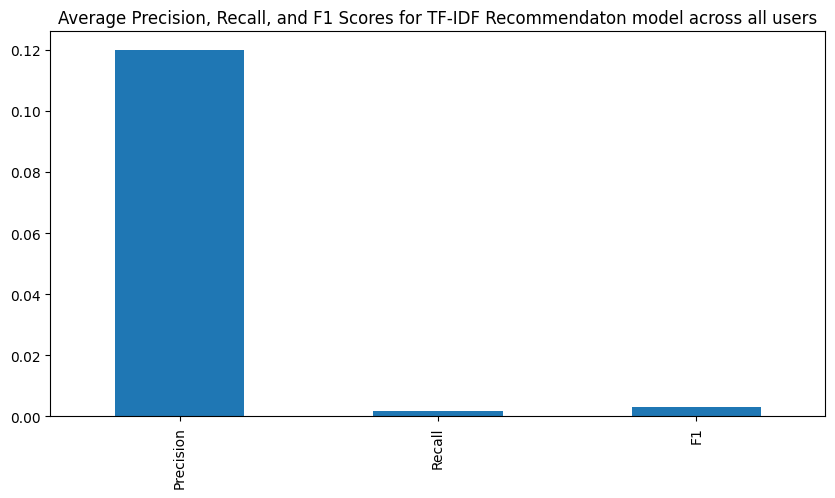

In [96]:
# Show the Precision, Recall, and F1 Scores averaged across all users on a line plot
scores_df.mean().plot(kind='bar', title='Average Precision, Recall, and F1 Scores for TF-IDF Recommendaton model across all users', figsize=(10, 5))
plt.show()

In [97]:
# Calculate the cosine similarity between matrix
cosine_sim_matrix = cosine_similarity(user_item_matrix)

In [98]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

KNN_NUM_USERS = 100

# Create a list of user IDs and item IDs
user_ids = ['user{}'.format(i) for i in range(1, KNN_NUM_USERS + 1)]

# Grab all Spotify IDs from the dataset
spotify_ids = df['spotify_id'].unique()

# Create a user-item matrix with random values for each user
data = np.random.randint(0, 101, size=(NUM_USERS, 6776))
user_item_matrix = pd.DataFrame(data=data, index=user_ids, columns=spotify_ids)

# Step 2: Compute item-item similarity using cosine similarity
item_similarity = cosine_similarity(user_item_matrix.T)

# Step 3: Identify k-nearest neighbors
k = 5  # Number of nearest neighbors to consider
# Create an array to store the indices of k-nearest neighbors for each item
k_nearest_neighbors = np.argpartition(item_similarity, -k, axis=1)[:, -k:]

# Step 4: Predict ratings
def predict_ratings(user_item_matrix, item_similarity, k_nearest_neighbors):
    predicted_ratings = np.zeros_like(user_item_matrix)
    for i in range(user_item_matrix.shape[0]):  # Loop over each user
        unrated_items = np.where(user_item_matrix.iloc[i] == 0)[0]  # Indices of unrated items
        for j in unrated_items:  # Loop over each unrated item
            # Compute predicted rating by aggregating ratings of k-nearest neighbors
            rated_items = np.where(user_item_matrix.iloc[i] != 0)[0]  # Indices of rated items
            numerator = np.sum(user_item_matrix.iloc[i].values[rated_items] * item_similarity[j][rated_items])
            denominator = np.sum(np.abs(item_similarity[j][rated_items]))
            if denominator != 0:
                predicted_ratings[i, j] = numerator / denominator

    return predicted_ratings

predicted_ratings = predict_ratings(user_item_matrix, item_similarity, k_nearest_neighbors)

# Step 5: Generate recommendations
def generate_recommendations(predicted_ratings, n=10):
    # Sort predicted ratings in descending order and select top-n songs as recommendations
    recommendations = np.argsort(predicted_ratings, axis=1)[:, :-n-1:-1]
    return recommendations

recommended_songs = generate_recommendations(predicted_ratings, n=10)

# print(recommended_songs)

# Generate recommendations for each user
knn_user_recommendations = {}
for i in range(user_item_matrix.shape[0]):
    knn_user_recommendations[user_item_matrix.index[i]] = recommended_songs[i]

In [99]:
# Loop through each user and their recommended songs and return the spotify IDs for the corresponding index of the recommended songs
knn_user_recommendations = {user: [df.iloc[recommendation]['spotify_id'] for recommendation in recommendations] for user, recommendations in knn_user_recommendations.items()}

In [100]:
# Call the evaluate recommendations function
knn_scores_df = evaluate_recommendations(user_recommendations=knn_user_recommendations, user_item_matrix=user_item_matrix, top_cols_df=top_cols_df)

# Set the index of the scores DataFrame to the user IDs
knn_scores_df.index = user_item_matrix.index

Average Precision:  0.103
Average Recall:  0.0013993203288624272
Average F1:  0.0027610972562977167


<Axes: title={'center': 'Average Precision, Recall, and F1 Scores for KNN Recommendation model across all users'}>

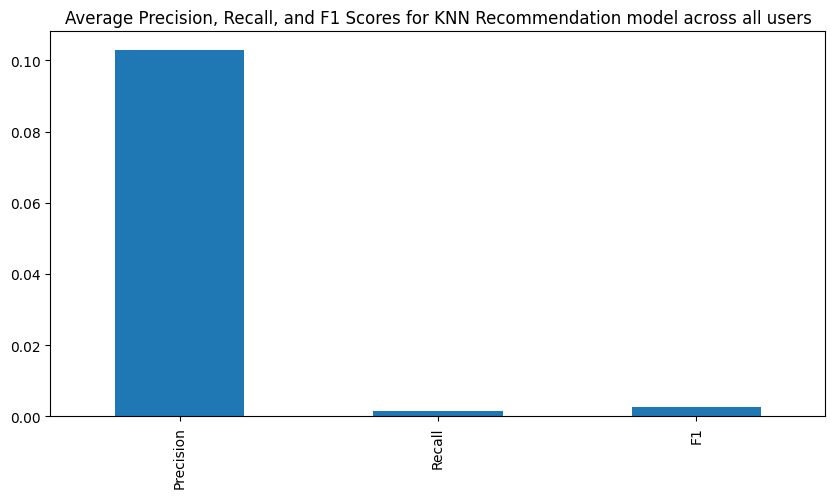

In [101]:
# Print the average precision, recall, and F1 scores
print("Average Precision: ", knn_scores_df['Precision'].mean())
print("Average Recall: ", knn_scores_df['Recall'].mean())
print("Average F1: ", knn_scores_df['F1'].mean())

# Show the Precision, Recall, and F1 Scores averaged across all users on a line plot
knn_scores_df.mean().plot(kind='bar', title='Average Precision, Recall, and F1 Scores for KNN Recommendation model across all users', figsize=(10, 5))

In [102]:
lstm_model = joblib.load('nlp_rnn.pkl')


2023-04-25 12:20:36.372238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-25 12:20:36.373214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-25 12:20:36.374577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [103]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________


In [104]:
print(lstm_model)

In [105]:
type(lstm_model)

keras.engine.sequential.Sequential

In [106]:

# Get the "clean_lyrics" column from the DataFrame
lyrics = df['clean_lyrics'].values

def encoding(lyrics):


    # Create a Tokenizer object
    tokenizer = Tokenizer(num_words=5000)

    # Fit the tokenizer on the text data
    tokenizer.fit_on_texts(lyrics)

    # Perform tokenization on the text data
    sequences = tokenizer.texts_to_sequences(lyrics)

    # Define the maximum sequence length for padding
    max_len = 500  # Set to an appropriate value based on your data

    # Pad the sequences to have the same length
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

    return padded_sequences, tokenizer

# Get the vocabulary size
vs = encoding(lyrics)[1]
vocab_size = len(vs.word_index) + 1

# The padded_sequences variable now contains the index-based encoded text data
# which can be used as input to an RNN model for training or prediction
# You can use the padded_sequences variable in your RNN model along with other features as needed



In [107]:
padded_sequences = encoding(lyrics)[0]
print(padded_sequences[0])

[  89   42  892   10  469  356  423    1 1224    6  168  447   11 2064
  493   86    9   44 1190    3   98  935    1  188  260  721  140 1465
  140  432   20    3 1979   47 2939   76 2984  416  279   95  151  129
  353   52    4   10  675   45   22  132  621  141   39 3387  548   75
    1 1542   97  109   53    5 1290    1   32  125   10  317  524 3500
   37  979   75  979   75   52   51 1296   10   13    6   53    5  581
 1673    1 2387  903 1123  379   62  156 1124   39  156  423   89   42
  892   10   69   47  212  315   15 1124   10   39  156  423   89   42
  892   10   69   47  212  315   15 1124   10  727 1397   52  104   41
  727 1397   80  167   86    9 1190    3   98  575    1  188 1567 2984
   98 1205    1  188   41 3681    4    1   85    1   85 2065  115    1
    8  945    1   85   35   39   35 1413 2853  575    6   98  970 2984
   15 3566   30 1124 1969  892   10  929   20    3   21  156  423   10
   30 1124 1969  892   10  929   20    3   21  156  423   10    0    0
    0 

In [112]:
# Use RNN model to predict sentiment for each song in the user playlist
def predict_sentiment(lyrics, model):
    # Encode the lyrics using the Tokenizer object
    padded_sequences = encoding(lyrics)[0]

    # Make predictions using the RNN model
    predictions = model.predict(padded_sequences)

    print(predictions)

    # Convert the predictions into sentiment labels
    sentiment_labels = ['positive' if prediction > 0.96833 else 'negative' for prediction in predictions]

    return sentiment_labels

# Get the sentiment labels for each song in the user playlist
sentiment_labels = predict_sentiment(user_playlist_lyrics, lstm_model)



270/270 [==============================] - 13s 50ms/step
[[0.9868329]
 [0.9868329]
 [0.9868329]
 ...
 [0.9868329]
 [0.9868329]
 [0.9868329]]


In [109]:
print(sentiment_labels.count('positive'))
print(sentiment_labels.count('negative'))

13548
0


In [133]:
df['sentiment'] = ''

# Loop through each row in the df dataframe
for i in range(df.shape[0]):
    # Get the index of the row
    index = df.index[i]

    # Get the lyrics for the song
    lyrics = df.loc[index, 'clean_lyrics']

    # Predict the sentiment of the lyrics
    sentiment = predict_sentiment([lyrics], lstm_model)[0]

    # Update the sentiment column with the predicted sentiment
    df.loc[index, 'sentiment'] = sentiment

print(df.head(5))

1/1 [==============================] - 0s 35ms/step
[[0.9868329]]
1/1 [==============================] - 0s 32ms/step
[[0.9868329]]
1/1 [==============================] - 0s 33ms/step
[[0.98683286]]
1/1 [==============================] - 0s 32ms/step
[[0.98683286]]
1/1 [==============================] - 0s 33ms/step
[[0.9868329]]
1/1 [==============================] - 0s 32ms/step
[[0.98683286]]
1/1 [==============================] - 0s 32ms/step
[[0.98683274]]
1/1 [==============================] - 0s 33ms/step
[[0.9868329]]
1/1 [==============================] - 0s 33ms/step
[[0.98683286]]
1/1 [==============================] - 0s 33ms/step
[[0.98689413]]
1/1 [==============================] - 0s 33ms/step
[[0.9868329]]
1/1 [==============================] - 0s 33ms/step
[[0.01494831]]
1/1 [==============================] - 0s 34ms/step
[[0.93089396]]
1/1 [==============================] - 0s 33ms/step
[[0.9868329]]
1/1 [==============================] - 0s 32ms/step
[[0.9868329]]
1/

In [139]:
# Grab the user's playlist lyrics from the user_playlists dictionary
user_playlist_lyrics = user_playlists[user]

# Grab the lyrics from the corresponding spotify IDs in the user_playlist_lyrics list
user_playlist_lyrics = df[df['spotify_id'].isin(user_playlist_lyrics)]['clean_lyrics'].values

# Encode the lyrics using the Tokenizer object
padded_sequences = encoding(user_playlist_lyrics)[0]

# Make predictions using the RNN model
predictions = lstm_model.predict(padded_sequences)


# Label each song in dataframe with correct sentiment label
for i in range(len(predictions)):
    if predictions[i] > 0.96833:
        df['sentiment'].iloc[i] = 'positive'
    else:
        df['sentiment'].iloc[i] = 'negative'

# Convert the predictions into sentiment labels
sentiment_labels = ['positive' if prediction > 0.96833 else 'negative' for prediction in predictions]

# Return songs that correspond with the ratio of positive and negative sentiment labels to the user
def recommend_songs(sentiment_labels, user_playlist_lyrics, user_playlists, user, df, n=10):
    # Get the number of positive and negative sentiment labels
    num_positive = sentiment_labels.count('positive')
    num_negative = sentiment_labels.count('negative')

    # Calculate the ratio of positive and negative sentiment labels
    positive_ratio = num_positive / (num_positive + num_negative)
    negative_ratio = num_negative / (num_positive + num_negative)

    # Return songs that correspond with the ratio of positive and negative sentiment labels to the user
    if positive_ratio > negative_ratio:
        # Return the top-n songs with the highest positive sentiment
        return df[df['clean_lyrics'].isin(user_playlist_lyrics)][df['sentiment'] == 'positive']['spotify_id'].values[:n]
    else:
        # Return the top-n songs with the highest negative sentiment
        return df[df['clean_lyrics'].isin(user_playlist_lyrics)][df['sentiment'] == 'negative']['spotify_id'].values[:n]
    
# Get the recommended songs for the user
rnn_recommended_songs = recommend_songs(sentiment_labels, user_playlist_lyrics, user_playlists, user, df, n=10)

# Convert this list to a dictionary
rnn_recommended_songs = {user: rnn_recommended_songs}

print(rnn_recommended_songs)

1/1 [==============================] - 0s 48ms/step
{'user100': array(['06gD2ZtK3Dzc1BYqWExQJJ', '13e6f8t7RKXuxZ0JdaaJRG',
       '2272QqVQiM9VYGac3O2dVd', '5Wd2bfQ7wc6GgSa32OmQU3',
       '0elaYQVBPOQSp7G3P9AQ7C', '6TrLJzbFF1ynWWBipAlf0g',
       '7zywdG4ysfC5XNBzjQAo2o', '1DSJNBNhGZCigg9ll5VeZv'], dtype=object)}


/var/folders/b8/tkxd7yxj1672bq9d4m_3xmhh0000gn/T/ipykernel_13747/500339079.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[df['clean_lyrics'].isin(user_playlist_lyrics)][df['sentiment'] == 'positive']['spotify_id'].values[:n]


In [140]:
# Call the evaluate recommendations function
rnn_scores_df = evaluate_recommendations(user_recommendations=rnn_recommended_songs, user_item_matrix=user_item_matrix, top_cols_df=top_cols_df)

print(rnn_scores_df)

   Precision    Recall       F1
0      0.125  0.001385  0.00274


Average Precision:  0.125
Average Recall:  0.0013850415512465374
Average F1:  0.0027397260273972607


<Axes: title={'center': 'Average Precision, Recall, and F1 Scores for RNN Recommendation model across all users'}>

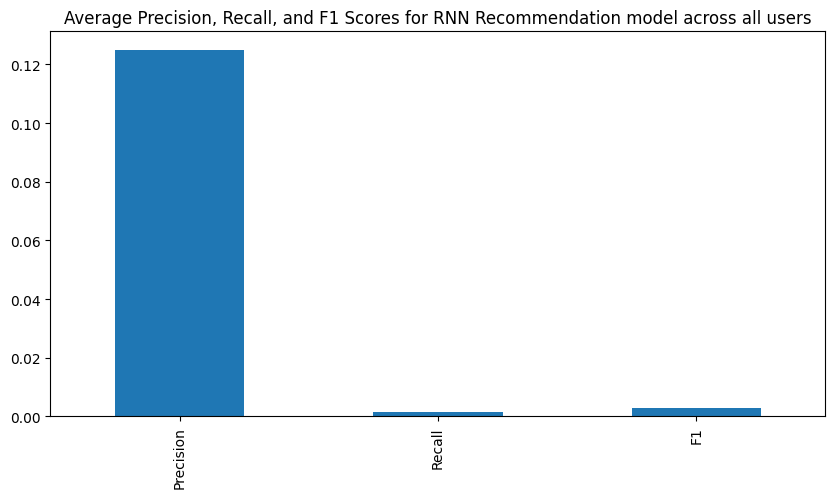

In [142]:


# Print the average precision, recall, and F1 scores
print("Average Precision: ", rnn_scores_df['Precision'].mean())
print("Average Recall: ", rnn_scores_df['Recall'].mean())
print("Average F1: ", rnn_scores_df['F1'].mean())

# Show the Precision, Recall, and F1 Scores averaged across all users on a line plot
rnn_scores_df.mean().plot(kind='bar', title='Average Precision, Recall, and F1 Scores for RNN Recommendation model across all users', figsize=(10, 5))


In [118]:
# Get top-n songs based on the number of times they appear in the user playlist
def get_top_n_songs(songs, top_cols_df, n=10):
    # Get the counts of each song in the user playlist
    song_counts = {song: songs.count(song) for song in songs}

    # Create a DataFrame with the song counts
    song_counts_df = pd.DataFrame.from_dict(song_counts, orient='index', columns=['Count'])

    # Join the song counts DataFrame with the top_cols_df DataFrame
    song_counts_df = song_counts_df.join(top_cols_df)

    # Sort the songs based on the count and return the top-n songs
    return song_counts_df.sort_values(by=['Count'], ascending=False).head(n)

# Recommend songs based on sentiment from the users playlist lyrics
def recommend_songs(sentiment_labels, user_playlist_lyrics, top_cols_df, user_item_matrix, n=10):
    # Get the indices of songs with positive sentiment
    positive_song_indices = [i for i, sentiment in enumerate(sentiment_labels) if sentiment == 'positive']

    # Get the indices of songs with negative sentiment
    negative_song_indices = [i for i, sentiment in enumerate(sentiment_labels) if sentiment == 'negative']

    # Get the songs with positive sentiment
    positive_songs = [user_playlist_lyrics[i] for i in positive_song_indices]

    # Get the songs with negative sentiment
    negative_songs = [user_playlist_lyrics[i] for i in negative_song_indices]

    # Get the top-n recommended songs for each sentiment
    positive_song_recommendations = get_top_n_songs(positive_songs, top_cols_df, user_item_matrix)
    negative_song_recommendations = get_top_n_songs(negative_songs, top_cols_df, user_item_matrix)

    return positive_song_recommendations, negative_song_recommendations

user_playlist_song_ids, user_playlist_lyrics = get_playlist_details(df=df, spotify_ids=sp_ids.sample(n=7))

# Get the top-n recommended songs for each sentiment
positive_song_recommendations, negative_song_recommendations = recommend_songs(sentiment_labels=sentiment_labels, user_playlist_lyrics=user_playlist_lyrics, top_cols_df=top_cols_df, user_item_matrix=user_item_matrix)

# Print the top-n recommended songs for each sentiment
print("Top-10 Recommended Songs for Positive Sentiment: ", positive_song_recommendations)
print("Top-10 Recommended Songs for Negative Sentiment: ", negative_song_recommendations)





Playlist User Enterd:
                  title        artist              spotify_id
1802           John Doe         b.o.b  0NIIKjRSjFVfjkgcgWlgQu
4261   God Must Be Busy        brooks  6ScrVCHKcvIc0D9WprKSvl
5103        Best Of You  foo fighters  1sn6iOK93jnp0Hn5BnNOXy
5402    Leave (Get Out)          jojo  12lONNhG7TQH6AL2MB2v58
5565          Suga Suga     baby bash  14B2bUopOga5V3ypld7d6n
6356  Imitation Of Life        r.e.m.  32kmXl5F8I3XDVKNfwwM4J
6424      Beautiful Day            u2  1VuBmEauSZywQVtqbxNqka


TypeError: cannot do positional indexing on Index with these indexers [         0XySogm94T51XF5F2jumXm  3qnoOm4fwZPBS116f5hpgF  \
user1                        13                      86   
user2                        18                      68   
user3                        54                      11   
user4                        40                      99   
user5                        28                      65   
...                         ...                     ...   
user96                       94                      79   
user97                       78                      25   
user98                       30                      99   
user99                       25                      24   
user100                      26                      74   

         4hQ6UGyWQIGJmHSo0J88JW  2Yl4OmDby9iitgNWZPwxkd  \
user1                        75                      21   
user2                        95                      68   
user3                        67                      87   
user4                        50                      76   
user5                        18                      92   
...                         ...                     ...   
user96                       58                       8   
user97                       38                      80   
user98                       54                      47   
user99                      100                      17   
user100                      24                      34   

         4Qx06Fzsepmdz2NGSWfZck  7dt6x5M1jzdTEt8oCbisTK  \
user1                         6                      68   
user2                        38                      74   
user3                        27                       5   
user4                        41                      75   
user5                        71                      44   
...                         ...                     ...   
user96                       29                       9   
user97                       68                      73   
user98                       44                      55   
user99                      100                      78   
user100                      81                      75   

         0At2qAoaVjIwWNAqrscXli  4MPTj8lMMvxLwT3EwuXFop  \
user1                        62                      65   
user2                        37                      29   
user3                        20                      57   
user4                        98                      82   
user5                        29                      59   
...                         ...                     ...   
user96                       35                      55   
user97                       81                      40   
user98                       45                      96   
user99                       47                      20   
user100                      15                      90   

         2gTYVoQCUh0QNUaFix01ld  4kUZvXB3LC3an3HX6h0s17  ...  \
user1                        74                      50  ...   
user2                        58                      16  ...   
user3                        74                      88  ...   
user4                       100                      27  ...   
user5                         3                      44  ...   
...                         ...                     ...  ...   
user96                       36                      58  ...   
user97                       52                      80  ...   
user98                       46                      30  ...   
user99                       31                      99  ...   
user100                     100                      46  ...   

         5pinOKTQyPCPpgjIOKVFY3  0CofintZCm8MhxiOMrauiT  \
user1                        52                       5   
user2                        25                      15   
user3                        94                      61   
user4                        86                      39   
user5                        17                       0   
...                         ...                     ...   
user96                       29                      11   
user97                       36                      89   
user98                       56                      88   
user99                       75                      16   
user100                      74                      10   

         2ZDxfuXmTIRCdXChbtHpW9  0jsANwwkkHyyeNyuTFq2XO  \
user1                         5                      63   
user2                        93                      76   
user3                        92                      80   
user4                        68                       2   
user5                        91                      23   
...                         ...                     ...   
user96                       84                      72   
user97                       81                      86   
user98                        4                      10   
user99                       52                      48   
user100                      46                      79   

         57eeWDF7qaIFj9q8oy9lfi  3ggPv9plkk3a5EfI4D9g2L  \
user1                        22                      68   
user2                        17                       8   
user3                        62                       9   
user4                        79                      72   
user5                        42                      27   
...                         ...                     ...   
user96                       81                      32   
user97                       90                      71   
user98                       59                       6   
user99                       69                      76   
user100                       5                      35   

         3MAQlKrBxFN5QXR7SqxYQh  2WNNMbA9vD52uU3N0iNBfc  \
user1                        55                      43   
user2                        31                      25   
user3                         3                      79   
user4                        96                      27   
user5                        89                     100   
...                         ...                     ...   
user96                       86                      44   
user97                       64                      13   
user98                       55                      57   
user99                       54                      53   
user100                      32                      89   

         4EQ0dK6Sg7v685NGrQvuki  2BNV1D5X4ioefyOE0uDFOL  
user1                         4                      50  
user2                        69                       1  
user3                        66                      39  
user4                        82                       9  
user5                        47                       8  
...                         ...                     ...  
user96                       95                      62  
user97                       98                      46  
user98                       72                       6  
user99                        7                       6  
user100                      93                       2  

[100 rows x 6776 columns]] of type DataFrame

In [ ]:
# Call the evaluate recommendations function
rnn_scores_df = evaluate_recommendations(user_recommendations=positive_song_recommendations, user_item_matrix=user_item_matrix, top_cols_df=top_cols_df)

In [ ]:
# Show the precision, recall, and f1 scores for the RNN model
print("Average Precision: ", rnn_scores_df['Precision'].mean())
print("Average Recall: ", rnn_scores_df['Recall'].mean())
print("Average F1: ", rnn_scores_df['F1'].mean())

Writing the Cleaned Dataframe to the Database

In [ ]:
hostname="localhost"
dbname="music_app"
uname="root"
pwd=pwd

Create SQLAlchemy engine to connect to MySQL DB

In [ ]:
# Create the connection to the database
engine = create_engine(f'mysql+pymysql://{uname}:{pwd}@{hostname}/{dbname}')

In [ ]:
# Create the dataframe to be inserted into the database
sql_df = df

# Insert the dataframe into the database
sql_df.to_sql(
    name='billboard',
    con=engine,
    schema=None,
    if_exists='replace',
    index=False,
    index_label=None,
    chunksize=None,
    dtype=None,
    method=None,
)

6776